In [1]:
import warnings
warnings.filterwarnings("ignore")  # "error", "ignore", "always", "default", "module" or "once"

In [2]:
import numpy as np
import pandas as pd
import random
import os
#from imutils import paths
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from sklearn import preprocessing

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K

from federated_utils_fedavg import *

In [3]:
#declear path to your data
drebin_data_path = '/home/gp/Desktop/ayushi-malware/SoCTA-2022/data/drebin.csv'
malgenome_data_path = '/home/gp/Desktop/ayushi-malware/SoCTA-2022/data/malgenome.csv'
kronodroid_data_path = '/home/gp/Desktop/ayushi-malware/SoCTA-2022/data/kronodroid.csv'
TUANDROMD_data_path='/home/gp/Desktop/ayushi-malware/SoCTA-2022/data/TUANDROMD.csv'



Drebin_data = pd.read_csv(drebin_data_path, header = None)

Malgenome_data = pd.read_csv(malgenome_data_path)

Tuandromd_data=pd.read_csv(TUANDROMD_data_path)

kronodroid_data=pd.read_csv(kronodroid_data_path)
Kronodroid_data = kronodroid_data.iloc[:,range(1,kronodroid_data.shape[1])]

In [7]:

all_avg =[]

all_std =[]

n_clients = [5,10,15]
n_round = [10,20]

dataset = ['Drebin', 'Malgenome', 'Kronodroid', 'Tuandromd' ]


for d in range(0,len(dataset)):
    if d == 0:
        use_data = Drebin_data
    elif d==1:
        use_data = Malgenome_data
    elif d==2:
        use_data = Kronodroid_data
    elif d==3:
        use_data = Tuandromd_data
        
        
    print('===================================================================================================')
    print('Working with:',dataset[d])
    print('===================================================================================================')

    for r in n_round: #number of rounds loop
        comms_round = r
        for cl in n_clients: #number of clients loop
            number_of_clients = cl

            # from sklearn.utils import shuffle
            # use_data = shuffle(use_data)
            # use_data
            print('---------------------------------------------')
            print('No. of Clients:', number_of_clients)
            print('No. of Rounds:', comms_round)
            print('---------------------------------------------')


            features = np.array(use_data.iloc[:,range(0,use_data.shape[1]-1)]) #feature set

            labels = use_data.iloc[:,-1] #labels --> B : Benign and S


            #Do feature scaling 


            X = preprocessing.StandardScaler().fit(features).transform(features)


            #binarize the labels
            lb = LabelBinarizer()
            y = lb.fit_transform(labels)


            #split data into training and test set
            X_train, X_test, y_train, y_test = train_test_split(X, 
                                                                y, shuffle=True,
                                                                test_size=0.2, 
                                                                random_state=100)



            #create clients -- Horizontal FL
            clients = create_clients(X_train, y_train, num_clients=number_of_clients, initial='client')

            #process and batch the training data for each client
            clients_batched = dict()
            for (client_name, data) in clients.items():
                clients_batched[client_name] = batch_data(data)


                #process and batch the test set  
            test_batched = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(len(y_test))

            #==============================================
            # Traditional FedAvg 2017
            #==============================================
            #-----------------------------------------------


            all_results=list()

            #create optimizer
            lr = 0.01 
            loss='binary_crossentropy'
            metrics = ['accuracy']
            optimizer = SGD(learning_rate=lr, 
                            decay=lr / comms_round, 
                            momentum=0.9
                           )

            #initialize global model
            smlp_global = SimpleMLP()
            global_model = smlp_global.build(X.shape[1],1)
            #-----------------------------------------------


            print('|=======================|')
            print('|Traditional FedAvg 2017|')
            print('|=======================|')

            #commence global training loop
            for comm_round in range(comms_round):

                # get the global model's weights - will serve as the initial weights for all local models
                global_weights = global_model.get_weights()

                #initial list to collect local model weights after scalling
                scaled_local_weight_list = list()

                #randomize client data - using keys
                client_names= list(clients_batched.keys())
                random.shuffle(client_names)

                #loop through each client and create new local model
                for client in client_names:
                    smlp_local = SimpleMLP()
                    local_model = smlp_local.build(X.shape[1],1)
                    local_model.compile(loss=loss, 
                                  optimizer=optimizer, 
                                  metrics=metrics)

                    #set local model weight to the weight of the global model
                    local_model.set_weights(global_weights)

                    #fit local model with client's data
                    local_model.fit(clients_batched[client], epochs=32, verbose=0)

                    #scale the model weights and add to list
                    scaling_factor = weight_scalling_factor(clients_batched, client)
                    scaled_weights = scale_model_weights(local_model.get_weights(), scaling_factor)
                    scaled_local_weight_list.append(scaled_weights)

                    #clear session to free memory after each communication round
                    K.clear_session()

                #to get the average over all the local model, we simply take the sum of the scaled weights
                average_weights = sum_scaled_weights(scaled_local_weight_list)

                #update global model 
                global_model.set_weights(average_weights)

                #test global model and print out metrics after each communications round
                for(X_test, Y_test) in test_batched:
                    global_acc, global_loss, global_f1, global_precision, global_recall, global_auc, global_fpr = test_model(X_test, Y_test, global_model, comm_round)
                    all_results.append([global_acc,global_loss.numpy(),global_f1, global_precision, global_recall, global_auc, global_fpr])



            all_R = pd.DataFrame(all_results, columns=['global_acc', 'global_loss', 'global_f1', 'global_precision', 'global_recall', 'global_auc', 'global_fpr'])
            flname = 'results/round-'+str(r)+'/'+str(cl)+'-clients/FedAvg-'+dataset[d]+'-results.csv'
            all_R.to_csv(flname, index=None)
            
            
            all_avg.append(np.concatenate(([dataset[d],r,cl],np.mean(all_results,axis=0)))) #Storing avg values for each dataset
            all_std.append(np.concatenate(([dataset[d],r,cl],np.std(all_results,axis=0)))) #Storing std values sfor each dataset
            

            
ALL_AVG = pd.DataFrame(all_avg, columns = ['global_acc', 'global_loss', 'global_f1', 'global_precision', 'global_recall', 'global_auc', 'global_fpr'])
ALL_AVG.to_csv('FedAvg-all-results.csv')

ALL_STD = pd.DataFrame(all_std, columns = ['global_acc', 'global_loss', 'global_f1', 'global_precision', 'global_recall', 'global_auc', 'global_fpr'])
ALL_STD.to_csv('FedAvg-all-std-results.csv')

Working with: Drebin
---------------------------------------------
No. of Clients: 5
No. of Rounds: 10
---------------------------------------------
|=======================|
|Traditional FedAvg 2017|
|=======================|
comm_round: 0 | global_acc: 97.972% | global_loss: 0.5655008554458618 | global_f1: 0.9723356009070295 | global_precision: 0.9781021897810219 | global_recall: 0.9666366095581606 | global_auc: 0.9950284687826302| flobal_FPR: 0.033363390441839495 
comm_round: 1 | global_acc: 98.138% | global_loss: 0.5645481944084167 | global_f1: 0.9746376811594203 | global_precision: 0.9790718835304822 | global_recall: 0.9702434625788999 | global_auc: 0.9955018801124981| flobal_FPR: 0.029756537421100092 
comm_round: 2 | global_acc: 98.172% | global_loss: 0.5642343163490295 | global_f1: 0.9751018560434586 | global_precision: 0.9790909090909091 | global_recall: 0.9711451758340848 | global_auc: 0.9955595726667397| flobal_FPR: 0.028854824165915238 
comm_round: 3 | global_acc: 98.271% | 

|=======================|
|Traditional FedAvg 2017|
|=======================|
comm_round: 0 | global_acc: 98.072% | global_loss: 0.564189612865448 | global_f1: 0.9737556561085974 | global_precision: 0.9772933696639419 | global_recall: 0.9702434625788999 | global_auc: 0.9958309413478026| flobal_FPR: 0.029756537421100092 
comm_round: 1 | global_acc: 98.172% | global_loss: 0.5632144212722778 | global_f1: 0.975191700496166 | global_precision: 0.9756317689530686 | global_recall: 0.9747520288548241 | global_auc: 0.9961383975525061| flobal_FPR: 0.025247971145175834 
comm_round: 2 | global_acc: 98.338% | global_loss: 0.5626136064529419 | global_f1: 0.9773960216998192 | global_precision: 0.9800543970988214 | global_recall: 0.9747520288548241 | global_auc: 0.9962535452430707| flobal_FPR: 0.025247971145175834 
comm_round: 3 | global_acc: 98.338% | global_loss: 0.5623502135276794 | global_f1: 0.977416440831075 | global_precision: 0.9791855203619909 | global_recall: 0.975653742110009 | global_auc: 

comm_round: 13 | global_acc: 98.205% | global_loss: 0.5638789534568787 | global_f1: 0.9756756756756757 | global_precision: 0.9747974797479748 | global_recall: 0.9765554553651938 | global_auc: 0.9959489380533915| flobal_FPR: 0.023444544634806132 
comm_round: 14 | global_acc: 98.172% | global_loss: 0.5638185739517212 | global_f1: 0.975236380009005 | global_precision: 0.9739208633093526 | global_recall: 0.9765554553651938 | global_auc: 0.9959570102626268| flobal_FPR: 0.023444544634806132 
comm_round: 15 | global_acc: 98.172% | global_loss: 0.5637704730033875 | global_f1: 0.975236380009005 | global_precision: 0.9739208633093526 | global_recall: 0.9765554553651938 | global_auc: 0.9959688811585614| flobal_FPR: 0.023444544634806132 
comm_round: 16 | global_acc: 98.172% | global_loss: 0.5637214183807373 | global_f1: 0.975236380009005 | global_precision: 0.9739208633093526 | global_recall: 0.9765554553651938 | global_auc: 0.9959895365174876| flobal_FPR: 0.023444544634806132 
comm_round: 17 | gl

comm_round: 4 | global_acc: 99.079% | global_loss: 0.5685943961143494 | global_f1: 0.9866156787762906 | global_precision: 0.9772727272727273 | global_recall: 0.9961389961389961 | global_auc: 0.9998921076765388| flobal_FPR: 0.003861003861003861 
comm_round: 5 | global_acc: 99.079% | global_loss: 0.5685652494430542 | global_f1: 0.9866156787762906 | global_precision: 0.9772727272727273 | global_recall: 0.9961389961389961 | global_auc: 0.9998998142710718| flobal_FPR: 0.003861003861003861 
comm_round: 6 | global_acc: 99.079% | global_loss: 0.5685581564903259 | global_f1: 0.9866156787762906 | global_precision: 0.9772727272727273 | global_recall: 0.9961389961389961 | global_auc: 0.9999152274601376| flobal_FPR: 0.003861003861003861 
comm_round: 7 | global_acc: 99.079% | global_loss: 0.5685498118400574 | global_f1: 0.9866156787762906 | global_precision: 0.9772727272727273 | global_recall: 0.9961389961389961 | global_auc: 0.9999229340546706| flobal_FPR: 0.003861003861003861 
comm_round: 8 | glob

comm_round: 6 | global_acc: 99.737% | global_loss: 0.5662449598312378 | global_f1: 0.9961389961389961 | global_precision: 0.9961389961389961 | global_recall: 0.9961389961389961 | global_auc: 0.9997688021640118| flobal_FPR: 0.003861003861003861 
comm_round: 7 | global_acc: 99.737% | global_loss: 0.5662087798118591 | global_f1: 0.9961389961389961 | global_precision: 0.9961389961389961 | global_recall: 0.9961389961389961 | global_auc: 0.9997688021640118| flobal_FPR: 0.003861003861003861 
comm_round: 8 | global_acc: 99.737% | global_loss: 0.5661885142326355 | global_f1: 0.9961389961389961 | global_precision: 0.9961389961389961 | global_recall: 0.9961389961389961 | global_auc: 0.9997688021640118| flobal_FPR: 0.003861003861003861 
comm_round: 9 | global_acc: 99.737% | global_loss: 0.5661634802818298 | global_f1: 0.9961389961389961 | global_precision: 0.9961389961389961 | global_recall: 0.9961389961389961 | global_auc: 0.9997688021640118| flobal_FPR: 0.003861003861003861 
comm_round: 10 | glo

comm_round: 19 | global_acc: 99.079% | global_loss: 0.5693642497062683 | global_f1: 0.9866156787762906 | global_precision: 0.9772727272727273 | global_recall: 0.9961389961389961 | global_auc: 0.9996223768678859| flobal_FPR: 0.003861003861003861 
---------------------------------------------
No. of Clients: 15
No. of Rounds: 20
---------------------------------------------
|=======================|
|Traditional FedAvg 2017|
|=======================|
comm_round: 0 | global_acc: 98.289% | global_loss: 0.5759789347648621 | global_f1: 0.9744597249508842 | global_precision: 0.992 | global_recall: 0.9575289575289575 | global_auc: 0.9987052921184657| flobal_FPR: 0.04247104247104247 
comm_round: 1 | global_acc: 98.947% | global_loss: 0.5719743371009827 | global_f1: 0.9845559845559846 | global_precision: 0.9845559845559846 | global_recall: 0.9845559845559846 | global_auc: 0.9993526460592329| flobal_FPR: 0.015444015444015444 
comm_round: 2 | global_acc: 99.079% | global_loss: 0.5706427097320557 |

|=======================|
|Traditional FedAvg 2017|
|=======================|
comm_round: 0 | global_acc: 94.644% | global_loss: 0.5266863703727722 | global_f1: 0.9491216339432255 | global_precision: 0.9554522090319423 | global_recall: 0.9428743961352657 | global_auc: 0.982771610928341| flobal_FPR: 0.0571256038647343 
comm_round: 1 | global_acc: 95.310% | global_loss: 0.5257810354232788 | global_f1: 0.9553185004571776 | global_precision: 0.9644307692307692 | global_recall: 0.946376811594203 | global_auc: 0.9854268981799248| flobal_FPR: 0.0536231884057971 
comm_round: 2 | global_acc: 95.444% | global_loss: 0.5244570374488831 | global_f1: 0.9565959522067788 | global_precision: 0.965780403741999 | global_recall: 0.9475845410628019 | global_auc: 0.9865160242755596| flobal_FPR: 0.05241545893719807 
comm_round: 3 | global_acc: 95.482% | global_loss: 0.5236762166023254 | global_f1: 0.9569512195121952 | global_precision: 0.9663793103448276 | global_recall: 0.9477053140096618 | global_auc: 0.98

comm_round: 12 | global_acc: 96.954% | global_loss: 0.5122061371803284 | global_f1: 0.9712038717483363 | global_precision: 0.9729696969696969 | global_recall: 0.9694444444444444 | global_auc: 0.9912976747427411| flobal_FPR: 0.030555555555555555 
comm_round: 13 | global_acc: 96.967% | global_loss: 0.5121992230415344 | global_f1: 0.9713318011370509 | global_precision: 0.9728616428398352 | global_recall: 0.9698067632850241 | global_auc: 0.9912908866062343| flobal_FPR: 0.030193236714975844 
comm_round: 14 | global_acc: 96.999% | global_loss: 0.5120881199836731 | global_f1: 0.9716324925905764 | global_precision: 0.9732218587180419 | global_recall: 0.970048309178744 | global_auc: 0.9912992608327481| flobal_FPR: 0.02995169082125604 
comm_round: 15 | global_acc: 96.986% | global_loss: 0.5120057463645935 | global_f1: 0.9715184132551248 | global_precision: 0.9728715029671794 | global_recall: 0.9701690821256038 | global_auc: 0.9912989321094305| flobal_FPR: 0.029830917874396134 
comm_round: 16 | g

comm_round: 4 | global_acc: 96.097% | global_loss: 0.520733654499054 | global_f1: 0.9630347836625864 | global_precision: 0.9664315251763561 | global_recall: 0.9596618357487923 | global_auc: 0.9878355114540353| flobal_FPR: 0.04033816425120773 
comm_round: 5 | global_acc: 96.174% | global_loss: 0.5202852487564087 | global_f1: 0.9637839147286822 | global_precision: 0.9665937803692906 | global_recall: 0.9609903381642512 | global_auc: 0.9881654510478384| flobal_FPR: 0.03900966183574879 
comm_round: 6 | global_acc: 96.148% | global_loss: 0.5198960304260254 | global_f1: 0.9635460821121472 | global_precision: 0.9662375516152538 | global_recall: 0.9608695652173913 | global_auc: 0.9884401322519649| flobal_FPR: 0.0391304347826087 
comm_round: 7 | global_acc: 96.180% | global_loss: 0.5196386575698853 | global_f1: 0.9638685468740543 | global_precision: 0.9660317845444619 | global_recall: 0.9617149758454107 | global_auc: 0.9886532189244698| flobal_FPR: 0.03828502415458937 
comm_round: 8 | global_acc

comm_round: 5 | global_acc: 98.656% | global_loss: 0.3921198844909668 | global_f1: 0.9917355371900827 | global_precision: 0.994475138121547 | global_recall: 0.989010989010989 | global_auc: 0.9986763236763236| flobal_FPR: 0.01098901098901099 
comm_round: 6 | global_acc: 98.656% | global_loss: 0.39192113280296326 | global_f1: 0.9917355371900827 | global_precision: 0.994475138121547 | global_recall: 0.989010989010989 | global_auc: 0.9987137862137861| flobal_FPR: 0.01098901098901099 
comm_round: 7 | global_acc: 98.656% | global_loss: 0.3917751610279083 | global_f1: 0.9917355371900827 | global_precision: 0.994475138121547 | global_recall: 0.989010989010989 | global_auc: 0.9986721611721612| flobal_FPR: 0.01098901098901099 
comm_round: 8 | global_acc: 98.656% | global_loss: 0.39168569445610046 | global_f1: 0.9917355371900827 | global_precision: 0.994475138121547 | global_recall: 0.989010989010989 | global_auc: 0.9986305361305362| flobal_FPR: 0.01098901098901099 
comm_round: 9 | global_acc: 98

comm_round: 17 | global_acc: 99.104% | global_loss: 0.38933971524238586 | global_f1: 0.9945130315500686 | global_precision: 0.9931506849315068 | global_recall: 0.9958791208791209 | global_auc: 0.9993215118215119| flobal_FPR: 0.004120879120879121 
comm_round: 18 | global_acc: 99.104% | global_loss: 0.38934895396232605 | global_f1: 0.9945130315500686 | global_precision: 0.9931506849315068 | global_recall: 0.9958791208791209 | global_auc: 0.9993589743589743| flobal_FPR: 0.004120879120879121 
comm_round: 19 | global_acc: 99.104% | global_loss: 0.3892928659915924 | global_f1: 0.9945130315500686 | global_precision: 0.9931506849315068 | global_recall: 0.9958791208791209 | global_auc: 0.9993381618381619| flobal_FPR: 0.004120879120879121 
---------------------------------------------
No. of Clients: 10
No. of Rounds: 20
---------------------------------------------
|=======================|
|Traditional FedAvg 2017|
|=======================|
comm_round: 0 | global_acc: 97.312% | global_loss: 0.

comm_round: 9 | global_acc: 98.656% | global_loss: 0.3923570513725281 | global_f1: 0.9917355371900827 | global_precision: 0.994475138121547 | global_recall: 0.989010989010989 | global_auc: 0.9963120213120213| flobal_FPR: 0.01098901098901099 
comm_round: 10 | global_acc: 98.656% | global_loss: 0.3922538161277771 | global_f1: 0.9917355371900827 | global_precision: 0.994475138121547 | global_recall: 0.989010989010989 | global_auc: 0.9963911088911088| flobal_FPR: 0.01098901098901099 
comm_round: 11 | global_acc: 98.768% | global_loss: 0.39216819405555725 | global_f1: 0.9924294562973159 | global_precision: 0.9944827586206897 | global_recall: 0.9903846153846154 | global_auc: 0.9963869463869464| flobal_FPR: 0.009615384615384616 
comm_round: 12 | global_acc: 98.768% | global_loss: 0.3920956254005432 | global_f1: 0.9924294562973159 | global_precision: 0.9944827586206897 | global_recall: 0.9903846153846154 | global_auc: 0.996399433899434| flobal_FPR: 0.009615384615384616 
comm_round: 13 | global

ValueError: 7 columns passed, passed data had 10 columns

In [8]:
ALL_AVG = pd.DataFrame(all_avg, columns = ['Dataset','Rounds','no-clients','global_acc', 'global_loss', 'global_f1', 'global_precision', 'global_recall', 'global_auc', 'global_fpr'])
ALL_AVG.to_csv('FedAvg-all-avg-results.csv')

ALL_STD = pd.DataFrame(all_std, columns = ['Dataset','Rounds','no-clients','global_acc', 'global_loss', 'global_f1', 'global_precision', 'global_recall', 'global_auc', 'global_fpr'])
ALL_STD.to_csv('FedAvg-all-std-results.csv')

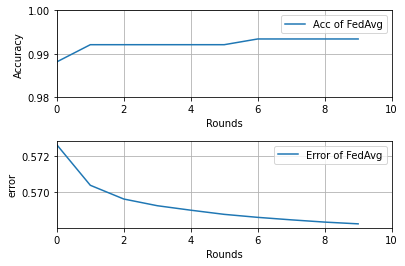

In [27]:
import numpy as np
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, 1)
# make a little extra space between the subplots
fig.subplots_adjust(hspace=0.5)

s1 = np.array(all_results) #FedAvg

t = range(0,s1.shape[0])

ax1.plot(t, s1[:,0],label='Acc of FedAvg')
ax1.set_xlim(0,s1.shape[0])
ax1.set_xlabel('Rounds')
ax1.set_ylabel('Accuracy')
ax1.set_ylim(0.98,1)
ax1.grid(True)
ax1.legend()


ax2.plot(t, s1[:,1],label='Error of FedAvg')
ax2.set_xlim(0, s1.shape[0])
ax2.set_xlabel('Rounds')
ax2.set_ylabel('error')
ax2.grid(True)
ax2.legend()

plt.show()



In [26]:
s1.shape

(10, 2)